<a href="https://colab.research.google.com/github/SantiagoVieiura/Lab2EDD2/blob/main/Lab2_edd2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

def leerArchivo(nombre):
  df = pd.read_csv(nombre)
  return df

Creación del nodo


In [ ]:
from graphviz import Digraph
import csv

class Nodo:
    def __init__(self,code,SAname, SAcity, SAcountry, SAlatitude, SAlongitude ,DAcode,DAname, DAcity, DAcountry, DAlatitude, DAlongitude ):
        self.code = code
        self.SAname = SAname
        self.SAcity = SAcity
        self.SAcountry = SAcountry
        self.SAlatitude = SAlatitude
        self.SAlongitude = SAlongitude
        self.DAcode = DAcode
        self.DAname = DAname
        self.DACity = DACity
        self.DAcountry = DAcountry
        self.DAlatitude = DAlatitude
        self.DAlongitude = DAlongitude





Haversine formula :😡


In [ ]:
import math

def haversine(lat1, lon1, lat2, lon2):

    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])


    dlat = lat2 - lat1
    dlon = lon2 - lon1


    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a))


    R = 6371
    distance = R * c

    return distance

codigo para saber si el grafo es conexo 😏

In [ ]:
def is_connected(graph):
    visited = set()

    def dfs(node):
        if node in visited:

            return visited.add(node)

        for neighbor in graph[node]:
            dfs(neighbor)


    start_node = next(iter(graph))
    dfs(start_node)

    return len(visited) == len(graph)

si entendi

In [ ]:
import math
import pandas as pd
from collections import defaultdict
import heapq
from graphviz import Graph
from IPython.display import Image, display
import os


# FORMULA HAVERSINA
def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat/2)**2 + math.cos(lat1)*math.cos(lat2)*math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a))
    return R * c


# VERTICE AEROPUERTO
class Airport:
    def __init__(self, code, name, city, country, lat, lon):
        self.code = code
        self.name = name
        self.city = city
        self.country = country
        self.lat = float(lat)
        self.lon = float(lon)

    def __repr__(self):
        return f"{self.code} - {self.city}, {self.country}"


# GRAFO
class Graph:
    def __init__(self):
        self.vertices = {}
        self.adj_list = defaultdict(list)

    def add_vertex(self, airport):
        if airport.code not in self.vertices:
            self.vertices[airport.code] = airport

    def add_edge(self, code1, code2, weight):


        self.adj_list[code1].append((code2, weight))
        self.adj_list[code2].append((code1, weight))

    def build_from_csv(self, path):
        data = pd.read_csv(path)
        for _, row in data.iterrows():
            src_code = row['Source Airport Code']
            dst_code = row['Destination Airport Code']


            if src_code not in self.vertices:
                src = Airport(src_code, row['Source Airport Name'], row['Source Airport City'],
                              row['Source Airport Country'], row['Source Airport Latitude'], row['Source Airport Longitude'])
                self.add_vertex(src)
            if dst_code not in self.vertices:
                dst = Airport(dst_code, row['Destination Airport Name'], row['Destination Airport City'],
                              row['Destination Airport Country'], row['Destination Airport Latitude'], row['Destination Airport Longitude'])
                self.add_vertex(dst)


            dist = haversine(row['Source Airport Latitude'], row['Source Airport Longitude'],
                             row['Destination Airport Latitude'], row['Destination Airport Longitude'])
            self.add_edge(src_code, dst_code, dist)


    # GRAFO CONEXO
    def connected_components(self):
        visited = set()
        components = []

        for vertex in self.vertices:
            if vertex not in visited:
                stack = [vertex]
                component = set()
                while stack:
                    v = stack.pop()
                    if v not in visited:
                        visited.add(v)
                        component.add(v)
                        for neighbor, _ in self.adj_list[v]:
                            if neighbor not in visited:
                                stack.append(neighbor)
                components.append(component)

        return components

    # CAMINOS MINIMOS
    def dijkstra(self, start):
        dist = {v: float('inf') for v in self.vertices}
        prev = {v: None for v in self.vertices}
        dist[start] = 0
        pq = [(0, start)]

        while pq:
            current_dist, current_vertex = heapq.heappop(pq)
            if current_dist > dist[current_vertex]:
                continue

            for neighbor, weight in self.adj_list[current_vertex]:
                distance = current_dist + weight
                if distance < dist[neighbor]:
                    dist[neighbor] = distance
                    prev[neighbor] = current_vertex
                    heapq.heappush(pq, (distance, neighbor))

        return dist, prev

    # ARBOL DE EXPANSION MINIMO
    def kruskal_msf(self):
        parent = {}
        rank = {}

        def find(v):
            if parent[v] != v:
                parent[v] = find(parent[v])
            return parent[v]

        def union(v1, v2):
            root1 = find(v1)
            root2 = find(v2)
            if root1 == root2:
                return False
            if rank[root1] < rank[root2]:
                parent[root1] = root2
            elif rank[root1] > rank[root2]:
                parent[root2] = root1
            else:
                parent[root2] = root1
                rank[root1] += 1
            return True

        for v in self.vertices:
            parent[v] = v
            rank[v] = 0

        edges = []
        for u in self.adj_list:
            for v, w in self.adj_list[u]:
                if u < v:
                    edges.append((w, u, v))
        edges.sort()

        msf = []

        for w, u, v in edges:
            if union(u, v):
                msf.append((u, v, w))

        components = defaultdict(list)
        for u, v, w in msf:
            root = find(u)
            components[root].append((u, v, w))

        return components

    #Dibujar GRAFOS O SUBGRAFOS
    def draw_graph(self, filename="graph", highlight_edges=None, highlight_nodes=None, limit_to_subgraph=False):
        dot = Graph(comment="Airport Graph", engine="sfdp")
        dot.attr(splines='true', overlap='false', rankdir='LR')
        dot.attr("node", shape="circle", style="filled", fontname="Arial", fontsize="10")

        # Determinar qué nodos se van a dibujar
        nodes_to_draw = set(self.vertices.keys())
        if limit_to_subgraph and highlight_nodes:
            nodes_to_draw = set(highlight_nodes)
            if highlight_edges:
              for u, v in highlight_edges:
                nodes_to_draw.add(u)
                nodes_to_draw.add(v)

        # Agregar nodos
        for code in nodes_to_draw:
          airport = self.vertices[code]
          label = f"{airport.code}\n{airport.city}"
          color = "gold" if highlight_nodes and code in highlight_nodes else "lightblue"
          dot.node(code, label=label, color=color, style="filled")

        # Agregar aristas
        added = set()
        for u in nodes_to_draw:
          for v, w in self.adj_list[u]:
            if v not in nodes_to_draw:
                continue
            if (v, u) in added:
                continue
            added.add((u, v))
            style = "bold" if highlight_edges and ((u, v) in highlight_edges or (v, u) in highlight_edges) else "solid"
            color = "red" if style == "bold" else "gray"
            dot.edge(u, v, label=f"{w:.1f}", color=color, style=style)

        # Renderizar el gráfico como PNG y mostrarlo
        output_path = dot.render(filename, format="png", cleanup=True)
        if os.path.exists(output_path):
          print(f"\n✅ Gráfico generado y guardado como: {output_path}")
          display(Image(filename=output_path))
        else:
          print("⚠️ No se pudo renderizar la imagen correctamente.")


def main():
    print("Cargando datos del grafo...")
    graph = Graph()
    graph.build_from_csv("flights_final.csv")
    print(f"Grafo cargado con {len(graph.vertices)} aeropuertos.")

    while True:
        print("\n===== MENÚ PRINCIPAL =====")
        print("1. Verificar si el grafo es conexo")
        print("2. Mostrar aeropuertos más lejanos desde un código")
        print("3. Mostrar camino mínimo entre dos aeropuertos")
        print("4. Calcular Árbol de Expansión Mínimo (por componente)")
        print("5. Salir")

        option = input("Seleccione una opción: ")

        if option == "1":
            comps = graph.connected_components()
            print(f"\nNúmero de componentes: {len(comps)}")
            for i, c in enumerate(comps):
                print(f"Componente {i+1}: {len(c)} vértices")
            graph.draw_graph("graph_components")

        elif option == "2":
            start = input("Ingrese código de aeropuerto origen: ").strip().upper()

            if start not in graph.vertices:
                print("Aeropuerto no encontrado.")
                continue


            airport = graph.vertices[start]
            print("\n=== Información del aeropuerto origen ===")
            print(f"Código: {airport.code}")
            print(f"Nombre: {airport.name}")
            print(f"Ciudad: {airport.city}")
            print(f"País: {airport.country}")
            print(f"Latitud: {airport.lat}")
            print(f"Longitud: {airport.lon}")


            dist, _ = graph.dijkstra(start)
            reachable = [(code, d) for code, d in dist.items() if d < float('inf') and code != start]

            if not reachable:
                print("\nNo hay otros aeropuertos alcanzables desde este.")
                continue


            reachable.sort(key=lambda x: x[1], reverse=True)

            print("\n=== 10 aeropuertos más lejanos (por caminos mínimos) ===")
            for code, d in reachable[:10]:
                a = graph.vertices[code]
                print(f"\nCódigo: {a.code}")
                print(f"Nombre: {a.name}")
                print(f"Ciudad: {a.city}")
                print(f"País: {a.country}")
                print(f"Latitud: {a.lat}")
                print(f"Longitud: {a.lon}")
                print(f"Distancia del camino: {d:.2f} km")
            highlight_nodes = [start] + [code for code, _ in reachable[:10]]
            graph.draw_graph("graph_farthest", highlight_nodes=[start] + [code for code, _ in reachable[:10]], limit_to_subgraph=True)
        elif option == "3":
            src = input("Ingrese aeropuerto origen: ").strip().upper()
            dst = input("Ingrese aeropuerto destino: ").strip().upper()
            if src not in graph.vertices or dst not in graph.vertices:
                print("Alguno de los aeropuertos no existe.")
                continue

            dist, prev = graph.dijkstra(src)
            if dist[dst] == float('inf'):
                print("No hay camino entre esos aeropuertos.")
            else:

                path = []
                current = dst
                while current is not None:
                    path.append(current)
                    current = prev[current]
                path.reverse()

                print(f"\nCamino mínimo ({dist[dst]:.2f} km):")
                for code in path:
                    a = graph.vertices[code]
                    print(f"{a.code} - {a.name}, {a.city}, {a.country}, {a.lat} - {a.lon}")

                highlight_edges = [(path[i], path[i+1]) for i in range(len(path)-1)]
                highlight_nodes = [src, dst]
                graph.draw_graph("graph_shortest_path", highlight_edges=[(path[i], path[i+1]) for i in range(len(path)-1)], highlight_nodes=[src, dst], limit_to_subgraph=True)

        elif option == "4":
            forest = graph.kruskal_msf()
            print("\n=== Árbol(es) de Expansión Mínimo ===")
            for i, (root, edges) in enumerate(forest.items(), start=1):
                total = sum(w for _, _, w in edges)
                print(f"\nComponente {i}:")
                print(f"  Total distancia: {total:.2f} km")
                for u, v, w in edges:
                    print(f"  {u} -- {v} : {w:.2f} km")

            highlight_edges = []
            for edges in forest.values():
                highlight_edges.extend([(u, v) for u, v, _ in edges])
            graph.draw_graph("graph_msf", highlight_edges=[(u, v) for edges in forest.values() for u, v, _ in edges], limit_to_subgraph=True)

        elif option == "5":
            print("Saliendo del programa...")
            break


        else:
            print("Opción inválida. Intente de nuevo.")



if __name__ == "__main__":
    main()

Cargando datos del grafo...
Grafo cargado con 3256 aeropuertos.

===== MENÚ PRINCIPAL =====
1. Verificar si el grafo es conexo
2. Mostrar aeropuertos más lejanos desde un código
3. Mostrar camino mínimo entre dos aeropuertos
4. Calcular Árbol de Expansión Mínimo (por componente)
5. Salir


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

✅ Imagen generada correctamente: test_grafo.png


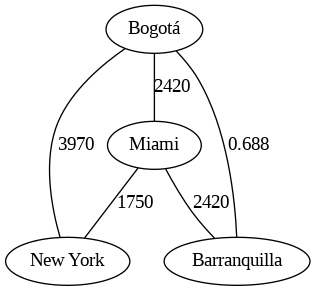

In [8]:
from graphviz import Graph
from IPython.display import Image, display
import os

def draw_graph_test():
    # Crear grafo
    dot = Graph(comment="Ejemplo simple")
    dot.node("BOG", "Bogotá")
    dot.node("MIA", "Miami")
    dot.node("JFK", "New York")
    dot.node("BAQ", "Barranquilla")
    dot.edge("BOG", "BAQ", label="0.688")
    dot.edge("BOG", "MIA", label="2420")
    dot.edge("MIA", "JFK", label="1750")
    dot.edge("MIA", "BAQ", label="2420")
    dot.edge("BOG", "JFK", label="3970")

    # Definir nombre del archivo y renderizar
    filename = "test_grafo"
    output_path = dot.render(filename, format="png", cleanup=True)

    # Verificar que el archivo existe
    if os.path.exists(output_path):
        print(f"✅ Imagen generada correctamente: {output_path}")
        display(Image(filename=output_path))
    else:
        print("⚠️ No se encontró la imagen generada. Verifica permisos o ruta.")

# Ejecutar la prueba
draw_graph_test()